###### In this notebook we will be doing some sentimental analysis in python using      two different techniques:

##  1.VADER(Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
##  2.Roberta Pretrained Model from 🤗
##  3.Huggingface Pipeline


# Step 1 :Read in Data and NLTK Basics

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.data.path.append("C:/nltk_data")
nltk.download('averaged_perceptron_tagger', download_dir="C:/nltk_data")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\TANUJ
[nltk_data]     GUPTA\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\TANUJ
[nltk_data]     GUPTA\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\TANUJ
[nltk_data]     GUPTA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
# Read in data
df = pd.read_csv('amazon.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(4915, 12)
(500, 12)


In [10]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


## Quick EDA

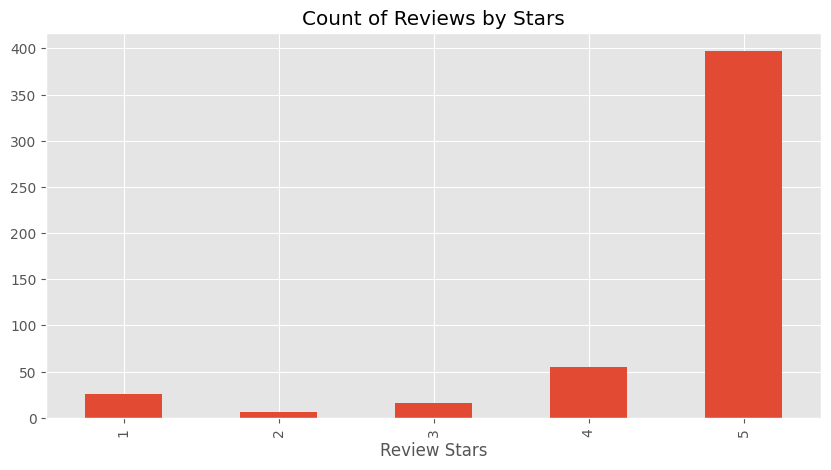

In [6]:
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [7]:
example = df['reviewText'][50]
print(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


In [8]:
from nltk.tokenize import TreebankWordTokenizer

word_tokenizer = TreebankWordTokenizer()
word_tokens = word_tokenizer.tokenize(example)
print(word_tokens[:10])


['A', 'memory', 'card', 'either', 'works', 'or', 'it', "doesn't.", 'This', 'was']


In [9]:
import nltk

tagged = nltk.pos_tag(word_tokens)
print(tagged[:10])  # View first 10 tagged tokens


[('A', 'DT'), ('memory', 'NN'), ('card', 'NN'), ('either', 'CC'), ('works', 'VBZ'), ('or', 'CC'), ('it', 'PRP'), ("doesn't.", 'VBZ'), ('This', 'DT'), ('was', 'VBD')]


In [11]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  A/DT
  memory/NN
  card/NN
  either/CC
  works/VBZ
  or/CC
  it/PRP
  doesn't./VBZ
  This/DT
  was/VBD
  always/RB
  going/VBG
  to/TO
  be/VB
  a/DT
  one/CD
  star/NN
  or/CC
  five/CD
  star/NN
  review/NN
  -/:
  no/DT
  middle/JJ
  ground.The/NN
  adapter/NN
  is/VBZ
  a/DT
  nice/JJ
  bonus/NN
  too/RB
  ,/,
  though/IN
  I/PRP
  do/VBP
  n't/RB
  think/VB
  I/PRP
  have/VBP
  anything/NN
  to/TO
  use/VB
  it/PRP
  with/IN
  ./.)


# Step 2. VADER Seniment Scoring
### We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

#### This uses a "bag of words" approach:
####    1.Stop words are removed
####    2.each word is scored and combined to a total score.

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [16]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [17]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [18]:
sia.polarity_scores(example)

{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [19]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['reviewText'])
    res[i] = sia.polarity_scores(text)

100%|██████████| 500/500 [00:00<00:00, 801.77it/s]


In [20]:
vaders = pd.DataFrame(res).T
vaders = vaders.merge(df, left_index=True, right_index=True)

In [21]:
# Now we have sentiment score and metadata
vaders.head()

,neg,neu,pos,compound,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0.688,0.312,0.000,-0.2960,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,0.075,0.925,0.000,-0.2960,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,0.077,0.923,0.000,-0.3089,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,0.000,0.909,0.091,0.7081,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,0.038,0.835,0.127,0.7087,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


# Plot VADER results

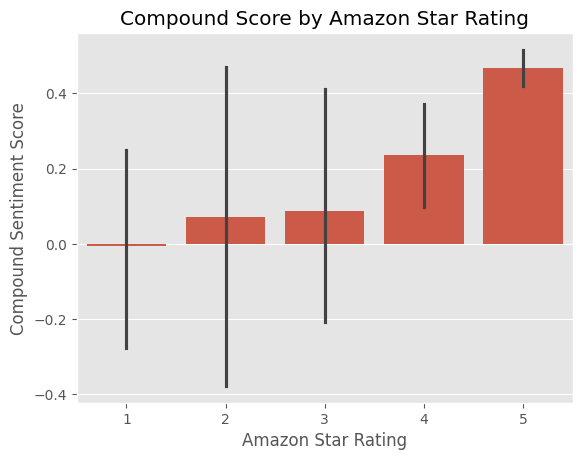

In [22]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compound Score by Amazon Star Rating')
plt.xlabel('Amazon Star Rating')
plt.ylabel('Compound Sentiment Score')
plt.show()


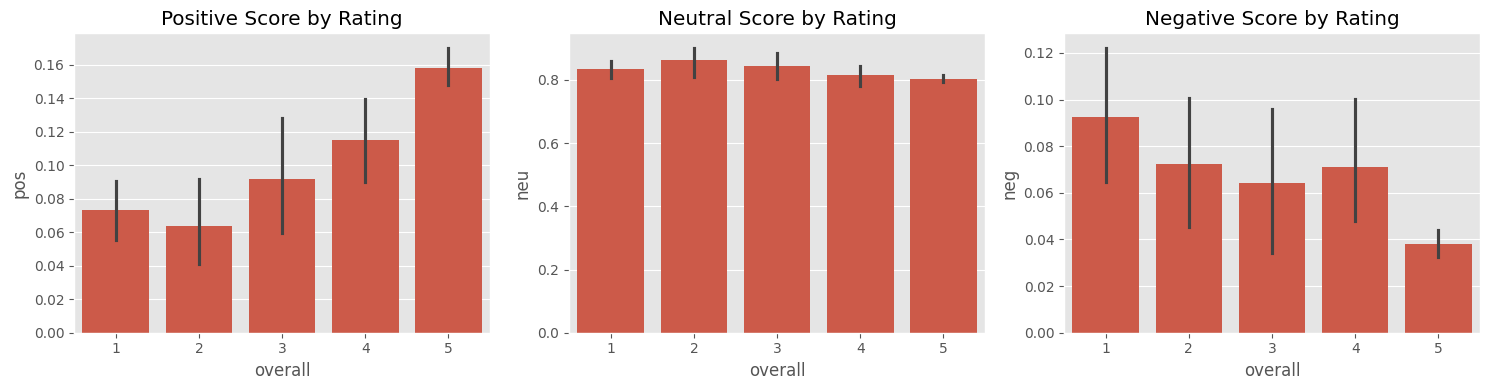

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])

axs[0].set_title('Positive Score by Rating')
axs[1].set_title('Neutral Score by Rating')
axs[2].set_title('Negative Score by Rating')

plt.tight_layout()
plt.show()


# Step 3. Roberta Pretrained Model
### Use a model trained of a large corpus of data.
### Transformer model accounts for the words but also the context related to other words.

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [26]:
# VADER results on example
example = df['reviewText'][50]
print(example)
sia.polarity_scores(example)

A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.


{'neg': 0.053, 'neu': 0.795, 'pos': 0.152, 'compound': 0.6249}

In [27]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.15133701), 'roberta_neu': np.float32(0.4059432), 'roberta_pos': np.float32(0.44271976)}


In [28]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [30]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = str(row['reviewText'])  # fixed column name
        myid = i  # using row index as ID

        # VADER
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{k}": v for k, v in vader_result.items()}

        # RoBERTa
        roberta_result = polarity_scores_roberta(text)

        # Merge both
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both

    except RuntimeError:
        print(f'⚠️ Skipped long or problematic review at index {i}')


 15%|█▌        | 76/500 [00:25<01:56,  3.63it/s]

⚠️ Skipped long or problematic review at index 76


 25%|██▌       | 125/500 [00:38<01:39,  3.78it/s]

⚠️ Skipped long or problematic review at index 123


100%|██████████| 500/500 [02:18<00:00,  3.60it/s]


In [32]:
results_df = pd.DataFrame(res).T

# Combine with df using the index
final_df = pd.concat([df, results_df], axis=1)


# Compare Scores between models

In [33]:
results_df.columns

Index(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos'],
      dtype='object')

# Step 3. Combine and compare

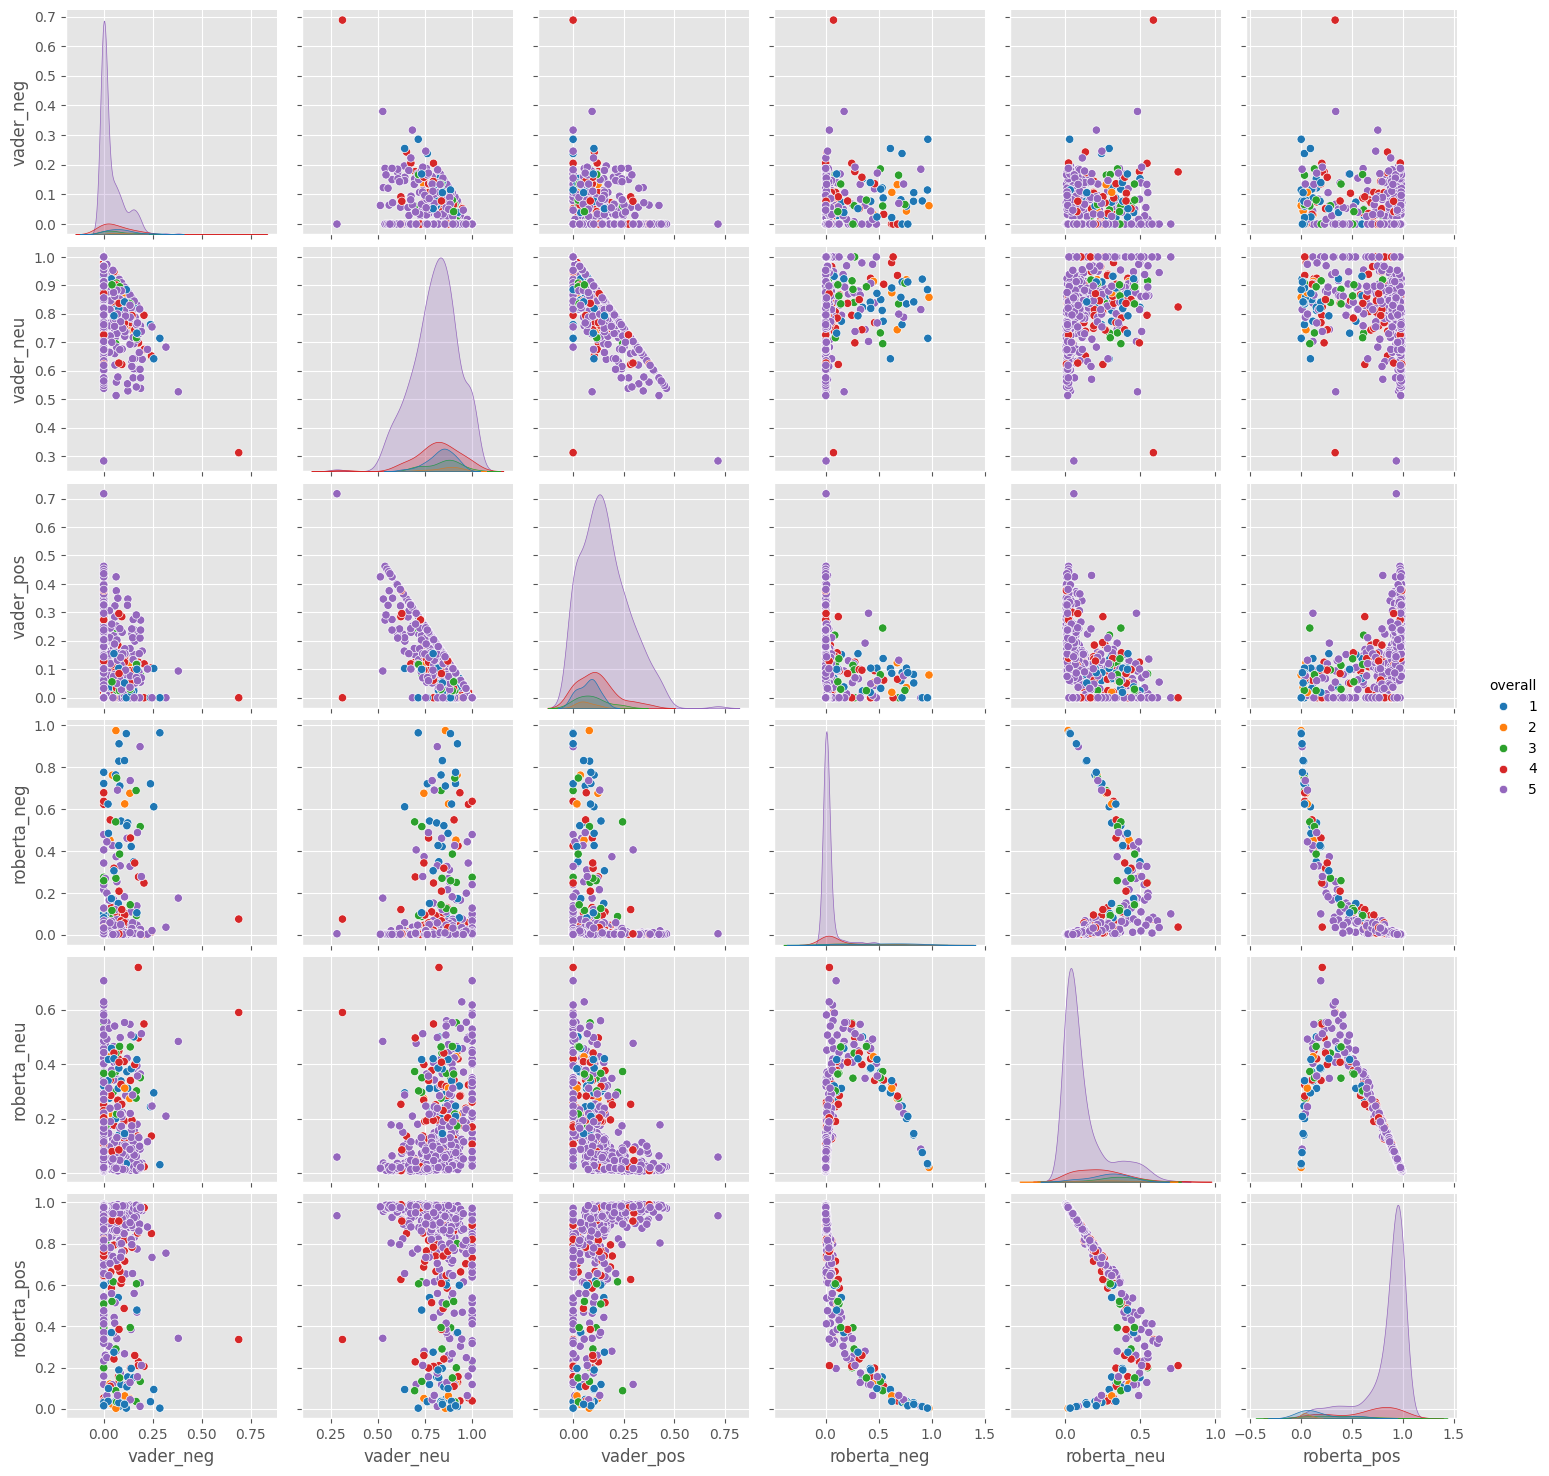

In [37]:
sns.pairplot(data=final_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='overall',
            palette='tab10')
plt.show()

# Step 4: Review Examples:
##      Positive 1-Star and Negative 5-Star Reviews
###      Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
# Most positive 1-star review (according to RoBERTa)
final_df.query('overall == 1') \
    .sort_values('roberta_pos', ascending=False)[['reviewText']].values[0]


'I bougth this micro SD card after some trubles with other that i got from Kingston, i can tell that SanDisk is other quality, this is the best, my i9300 phone can read a 64GB very fast, the dta transfer speed from my pc to my is amazing, if you are looking for additional storage to you phone, for music, pictures and other type of files, this is for you.Pros-Very good quality materials of construction-Amazing speedUpdate after one year this memory is damaged I can not delete or put new files on it, I can not format this memory, I tried to format with my phone, with my pc, with a camera and nothing, now this is like a 64gb cd, the data in the memory is only available to read but I can not move, or delete it, I bought this memory to be used to backup all my data of my android device but now is only a readable memory I can not write data on it any more, I hope sandisk make a better products in the future!!! Total disagree I will buy a Samsung memory card expected a better quality.'

In [40]:
# Most positive 1-star review (according to VADER)
final_df.query('overall == 1') \
    .sort_values('vader_pos', ascending=False)[['reviewText']].values[0]


array(["I really want to like these and I do trust SanDisk more than other manufacturers of memory cards. That said, I'm moving on to my 3rd card. Thank you Amazon for having exceptional customer service, or else I'd be very upset.Basically this card will suddenly not allow writing to it anymore. You can't save files to it, you can't delete files from it and you can't event format it. I've tried doing all three in different OS'es and devices with no luck. Doing some reading on the SanDisk forums this seems to be happening a lot with these cards.I'm returning this to Amazon and trying my luck with a different brand to see what happens."],
      dtype=object)

In [41]:
# nevative sentiment 5-Star view

In [43]:
# Most negative sentiment 5-star review (RoBERTa)
final_df.query('overall == 5') \
    .sort_values('roberta_neg', ascending=False)['reviewText'].values[0]


'Appears to be Class 10, holds about as much as it says it does, came with an SD card adapter and they even gave me the option to forgo those ridiculous plastic packages that you all know and hate. The ones that the scissors refuse to cut and you just end up hurting yourself a few times before getting it open. Completely as advertised.'

In [44]:
# Most negative sentiment 5-star review (VADER)
final_df.query('overall == 5') \
    .sort_values('vader_neg', ascending=False)['reviewText'].values[0]


'This works with the NL1520.  No video stuttering like with the 64gb.  Blah blah blah blah to fill in the rest.'

#  Extra: The Transformers Pipeline
##        Quick & easy way to run sentiment predictions

In [46]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\TANUJ GUPTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TANUJ GUPTA\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, 

In [47]:
sent_pipeline("I love sentiment analysis!")
# ➜ [{'label': 'POSITIVE', 'score': 0.999...}]


[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [48]:
sent_pipeline("booo")
# ➜ [{'label': 'NEGATIVE', 'score': 0.998...}]


[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The End